# Assignment 2 Question 7

## Ahmad Soni - 668564

## Nasiem Ayob - 1825850

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
import math
import seaborn as sns
import geopandas
from scipy import stats
from matplotlib.pyplot import figure
from datetime import datetime, date, time
import fiona

## part 1

First we load in our cleaned dataset and set a consistent CRS for the notebook to ensure our geoplot points are plotted correctly onto our scalemap

In [2]:
crs={'init':'epsg:4326'}

We use a very general CRS of EPSG4326 which is used in many world maps

In [3]:
df = pd.read_csv('cleaned.csv')

df_test = pd.read_csv('cleaned.csv')

#Removing rows with missing values
my_list = df['trip_duration'].values.tolist()
indices = [i for i, x in enumerate(my_list) if x == " "]
df = df.drop(indices)

df_test = df.copy()

df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration(hour),distance(km),speed(km/h),day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,1.498521,11.856428,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,1.805507,9.803659,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,6.385098,10.822201,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,1.485498,12.465721,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,1.188588,9.836594,Saturday


In [4]:
df.dtypes

id                      object
vendor_id                int64
pickup_datetime         object
dropoff_datetime        object
passenger_count          int64
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag      object
trip_duration            int64
trip_duration(hour)    float64
distance(km)           float64
speed(km/h)            float64
day                     object
dtype: object

We need to remove outliers not defined within our co-ordinate frame for our shapefile otherwise we will be unable to plot the points

In [5]:

outlier = df.drop(df[(df.pickup_longitude < -74.255591)].index)
outlier = outlier.drop(outlier[(outlier.pickup_longitude > -73.700009)].index)
outlier = outlier.drop(outlier[(outlier.pickup_latitude < 40.496133)].index)
outlier = outlier.drop(outlier[(outlier.pickup_latitude > 40.915532)].index)
outlier = outlier.drop(outlier[(outlier.passenger_count > 4)].index)

outlier = outlier.drop(outlier[(outlier.dropoff_longitude < -74.255591)].index)
outlier = outlier.drop(outlier[(outlier.dropoff_longitude > -73.700009)].index)
outlier = outlier.drop(outlier[(outlier.dropoff_latitude < 40.496133)].index)
outlier = outlier.drop(outlier[(outlier.dropoff_latitude > 40.915532)].index)

#outlier['pickup_datetime'] = pd.to_datetime(outlier['pickup_datetime']).dt.time
#outlier['dropoff_datetime'] = pd.to_datetime(outlier['dropoff_datetime']).dt.time



outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration(hour),distance(km),speed(km/h),day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,1.498521,11.856428,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,1.805507,9.803659,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,6.385098,10.822201,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,1.485498,12.465721,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,1.188588,9.836594,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,0.216111,1.225080,5.668751,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,0.181944,6.049836,33.251005,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,0.212222,7.824606,36.869870,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,0.103611,1.092564,10.544853,Tuesday


We are going to start by visualizing pickup points

In [6]:
pickup = geopandas.GeoDataFrame(outlier, geometry=geopandas.points_from_xy(outlier.pickup_longitude,outlier.pickup_latitude))
pickup

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration(hour),distance(km),speed(km/h),day,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,1.498521,11.856428,Monday,POINT (-73.98215 40.76794)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,1.805507,9.803659,Sunday,POINT (-73.98042 40.73856)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,6.385098,10.822201,Tuesday,POINT (-73.97903 40.76394)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,1.485498,12.465721,Wednesday,POINT (-74.01004 40.71997)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,1.188588,9.836594,Saturday,POINT (-73.97305 40.79321)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,0.216111,1.225080,5.668751,Friday,POINT (-73.98220 40.74552)
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,0.181944,6.049836,33.251005,Sunday,POINT (-74.00095 40.74738)
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,0.212222,7.824606,36.869870,Friday,POINT (-73.95913 40.76880)
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,0.103611,1.092564,10.544853,Tuesday,POINT (-73.98208 40.74906)


In [7]:
pickup_points = pickup.geometry
pickup_points

0          POINT (-73.98215 40.76794)
1          POINT (-73.98042 40.73856)
2          POINT (-73.97903 40.76394)
3          POINT (-74.01004 40.71997)
4          POINT (-73.97305 40.79321)
                      ...            
1458639    POINT (-73.98220 40.74552)
1458640    POINT (-74.00095 40.74738)
1458641    POINT (-73.95913 40.76880)
1458642    POINT (-73.98208 40.74906)
1458643    POINT (-73.97954 40.78175)
Name: geometry, Length: 1330933, dtype: geometry

In [8]:
world = geopandas.read_file('boroughs.shp')
world.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904856,"POLYGON ((-73.80379 40.77561, -73.80099 40.775..."
1,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.711894,"POLYGON ((-73.86110 40.76366, -73.85993 40.762..."
2,4.0,Queens,081,QN41,Fresh Meadows-Utopia,2.777485e+07,22106.431272,"POLYGON ((-73.77758 40.73019, -73.77849 40.729..."
3,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700375,"POLYGON ((-73.97301 40.76428, -73.97141 40.763..."
4,2.0,Bronx,005,BX09,Soundview-Castle Hill-Clason Point-Harding Park,5.198380e+07,67340.977626,"MULTIPOLYGON (((-73.88064 40.81852, -73.88098 ..."


We load in the shapefile to get a visual representation of what it's going to look like

<AxesSubplot:>

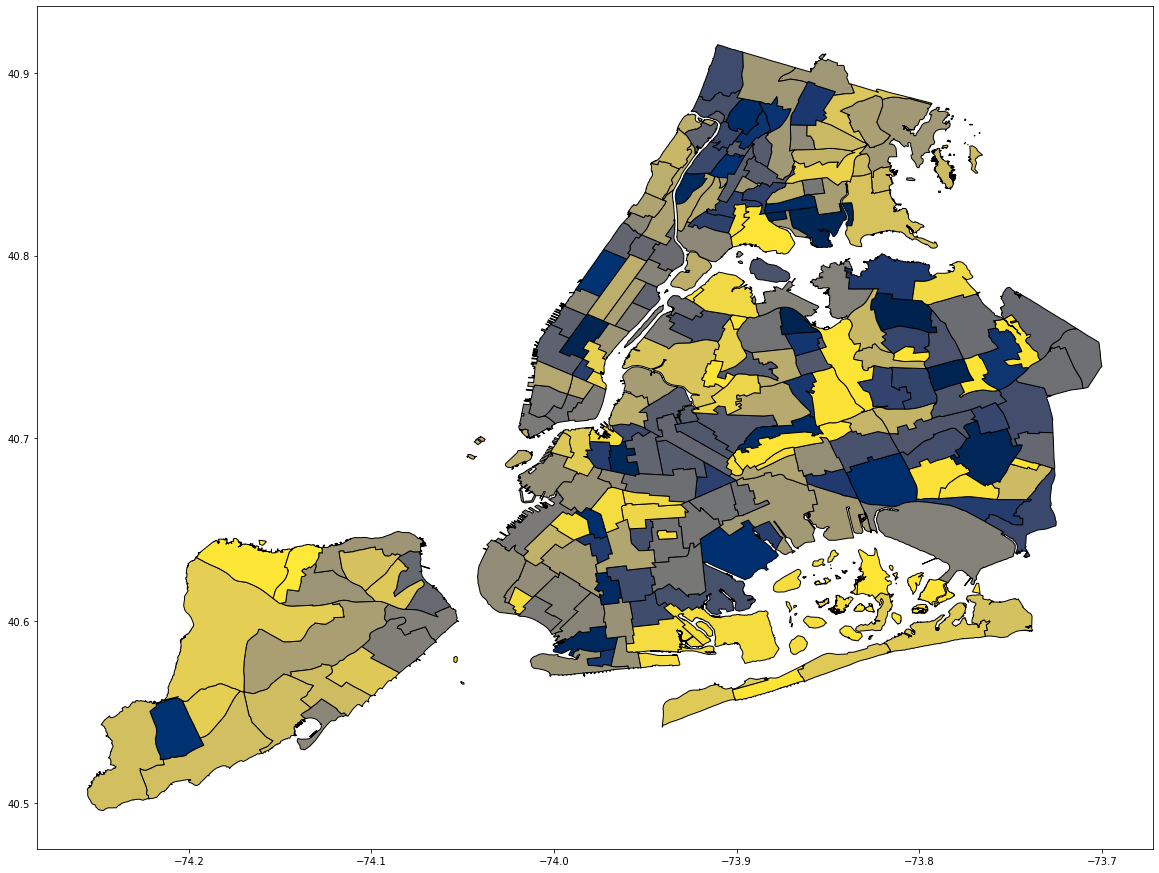

In [9]:
fig, ax = plt.subplots(figsize=(20,20))
world.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")

We now plot our pickup points onto the map

<AxesSubplot:>

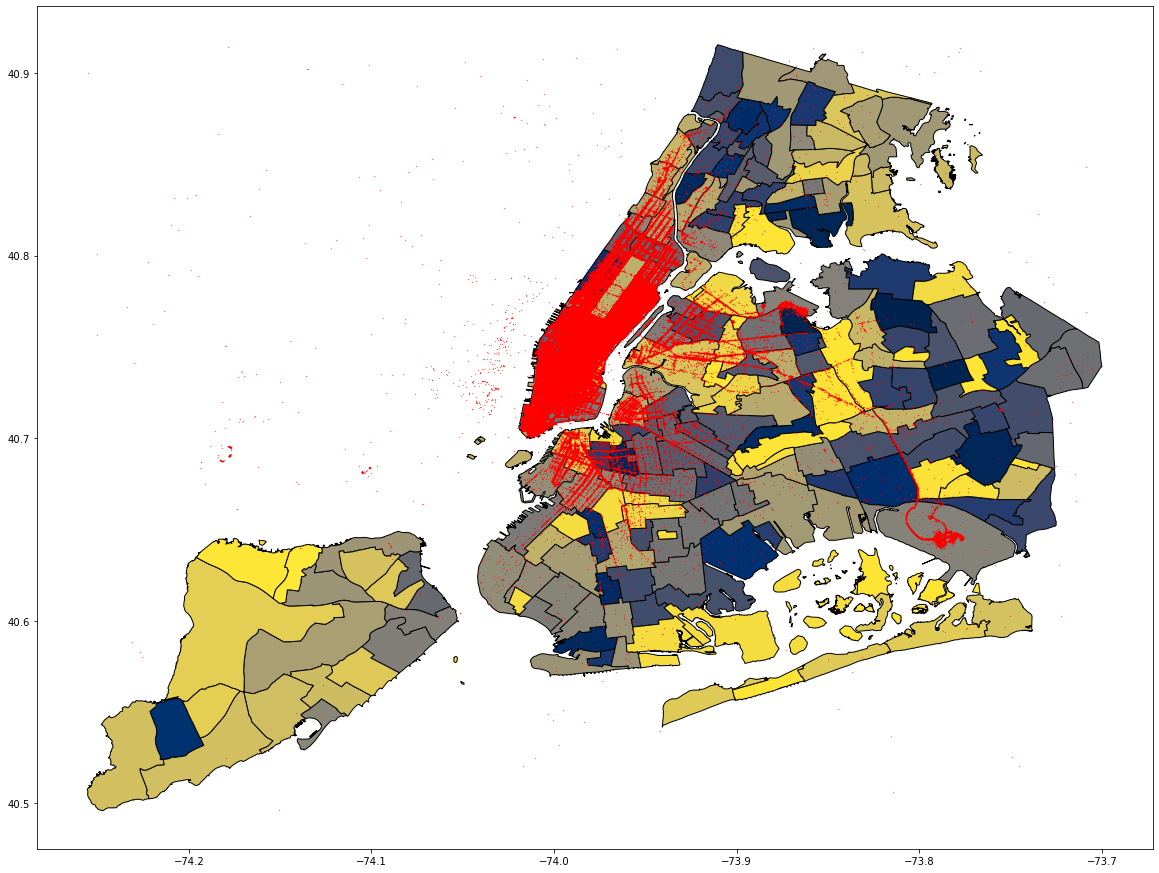

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
#ax = world.plot( color='white', edgecolor='black',figsize = (50,50))
world.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")
pickup_points.plot(ax=ax, color='red', markersize = 0.05)


we now do the same thing for the dropoff points

In [11]:
dropoff = geopandas.GeoDataFrame(outlier, geometry=geopandas.points_from_xy(outlier.dropoff_longitude,outlier.dropoff_latitude))
dropoff

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration(hour),distance(km),speed(km/h),day,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,1.498521,11.856428,Monday,POINT (-73.96463 40.76560)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,1.805507,9.803659,Sunday,POINT (-73.99948 40.73115)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,6.385098,10.822201,Tuesday,POINT (-74.00533 40.71009)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,1.485498,12.465721,Wednesday,POINT (-74.01227 40.70672)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,1.188588,9.836594,Saturday,POINT (-73.97292 40.78252)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,0.216111,1.225080,5.668751,Friday,POINT (-73.99491 40.74017)
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,0.181944,6.049836,33.251005,Sunday,POINT (-73.97018 40.79655)
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,0.212222,7.824606,36.869870,Friday,POINT (-74.00443 40.70737)
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,0.103611,1.092564,10.544853,Tuesday,POINT (-73.97463 40.75711)


In [12]:
dropoff_points = dropoff.geometry
dropoff_points

0          POINT (-73.96463 40.76560)
1          POINT (-73.99948 40.73115)
2          POINT (-74.00533 40.71009)
3          POINT (-74.01227 40.70672)
4          POINT (-73.97292 40.78252)
                      ...            
1458639    POINT (-73.99491 40.74017)
1458640    POINT (-73.97018 40.79655)
1458641    POINT (-74.00443 40.70737)
1458642    POINT (-73.97463 40.75711)
1458643    POINT (-73.97281 40.79058)
Name: geometry, Length: 1330933, dtype: geometry

<AxesSubplot:>

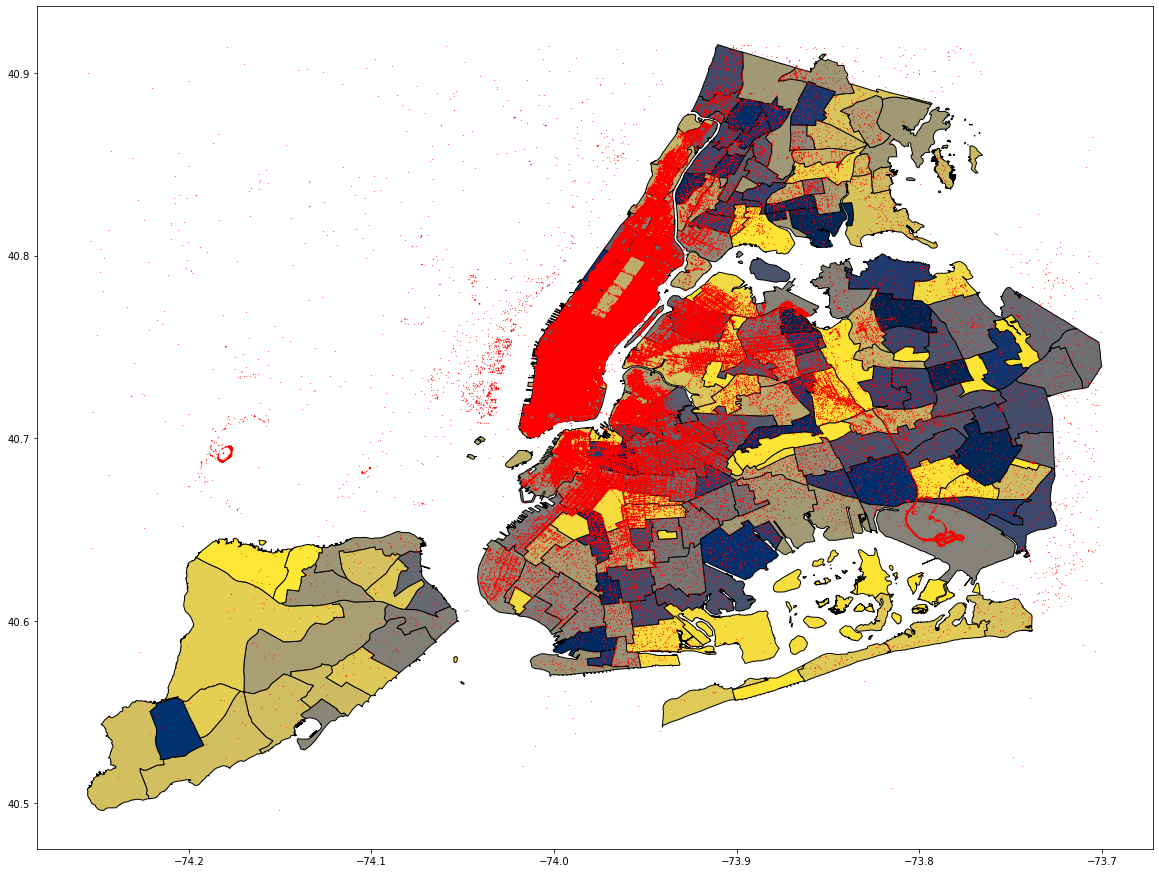

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
#ax = world.plot( color='white', edgecolor='black',figsize = (50,50))
world.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")
dropoff_points.plot(ax=ax, color='red', markersize = 0.05)

We can see there exists some outliers still despite our earlier removal. If we want to be 100% precise with our outlier removal, we would have to construct a multi-polygon area around the nyc landmass and then exclude all points not within the multi-polygon

## Part 2

In [14]:
map_df = geopandas.read_file('boroughs.shp')
map_df.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904856,"POLYGON ((-73.80379 40.77561, -73.80099 40.775..."
1,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.711894,"POLYGON ((-73.86110 40.76366, -73.85993 40.762..."
2,4.0,Queens,081,QN41,Fresh Meadows-Utopia,2.777485e+07,22106.431272,"POLYGON ((-73.77758 40.73019, -73.77849 40.729..."
3,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700375,"POLYGON ((-73.97301 40.76428, -73.97141 40.763..."
4,2.0,Bronx,005,BX09,Soundview-Castle Hill-Clason Point-Harding Park,5.198380e+07,67340.977626,"MULTIPOLYGON (((-73.88064 40.81852, -73.88098 ..."


<AxesSubplot:>

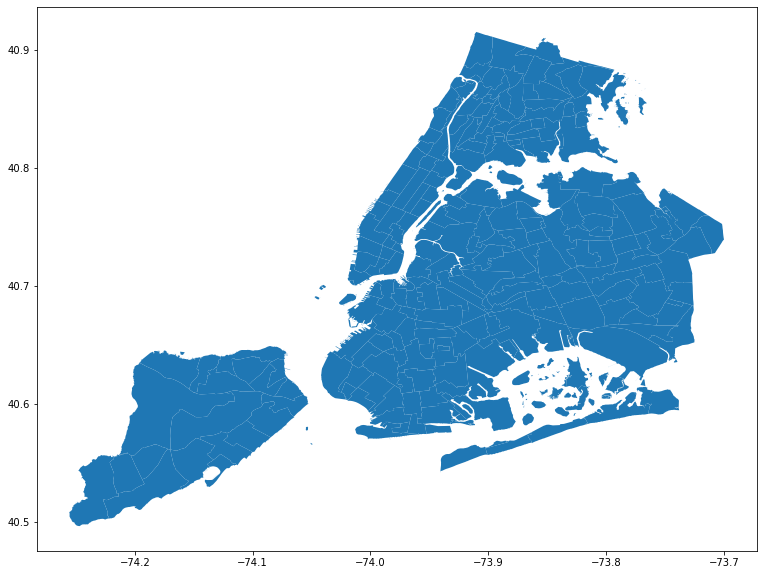

In [15]:
map_df.plot(figsize=(20, 10))

In [16]:
map_df = map_df.drop(['boro_code', 'county_fip', 'ntacode', 'ntaname', 'shape_area', 'shape_leng'], axis=1)
map_df.columns = ['District','geometry']

In [17]:
map_df.head()

,District,geometry
0,Queens,"POLYGON ((-73.80379 40.77561, -73.80099 40.775..."
1,Queens,"POLYGON ((-73.86110 40.76366, -73.85993 40.762..."
2,Queens,"POLYGON ((-73.77758 40.73019, -73.77849 40.729..."
3,Manhattan,"POLYGON ((-73.97301 40.76428, -73.97141 40.763..."
4,Bronx,"MULTIPOLYGON (((-73.88064 40.81852, -73.88098 ..."


In [18]:
counts = map_df['District'].value_counts()
counts

Queens           58
Brooklyn         51
Bronx            38
Manhattan        29
Staten Island    19
Name: District, dtype: int64

In [19]:
def countDistrict(row):
    c = 0
    
    if row == "Queens": c = 58
        
    if row == "Brooklyn": c = 51
        
    if row == "Bronx": c = 38
        
    if row == "Manhattan": c = 29
    
    if row == "Staten Island": c = 19
    
    return c  

In [20]:
map_df['Sum'] = map_df.apply (lambda row: countDistrict(row[0]), axis=1)

(-74.28337047814922, -73.67222994821337, 40.47516404814216, 40.93650271647433)

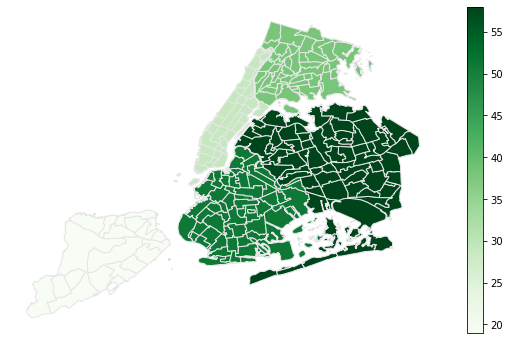

In [21]:
fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='Sum', cmap='Greens', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')

## Part 3

From our earlier plots, we can see that the borough that sees both the most outgoing and ingoing traffic is definitely Manhattan. This makes sense as Manhattan is a central business area for New York as well as commercial. This means it sees a large number of commuters and shoppers moving in and out of the borough on a daily basis. It is followed by Brooklyn and then Queens. Our least popular borough is Staten Island, which, again, makes sense as it is off the mainland and requires the usage of a bride. A bridge would restrict traffic since it only allows a limited number of vehicles at a time

## Part 4 and Part 5

We want to investigate the activity in the boroughs between midnight and 5am, so we need to filter these times out and investigate. We want to convert our datetime to an integer value to make it easier to filter

In [22]:
df2 = outlier.copy()

In [23]:
df2['pickup_datetime'] = pd.to_datetime(df2['pickup_datetime'], errors='coerce')
df2['dropoff_datetime'] = pd.to_datetime(df2['dropoff_datetime'], errors='coerce')


In [24]:
df2['pickup_datetime'] = df2['pickup_datetime'].dt.strftime('%H')
df2['dropoff_datetime'] = df2['dropoff_datetime'].dt.strftime('%H')


In [25]:
df2['pickup_datetime'] = df2['pickup_datetime'].astype(int)
df2['dropoff_datetime'] = df2['dropoff_datetime'].astype(int)

First we will look at pickups in this timeframe

In [26]:
Epickups = df2['pickup_datetime']>= int('00')
Epickups = df2['pickup_datetime']<= int('05')
EpickupsF = df2[Epickups]


In [27]:
EpickG = geopandas.GeoDataFrame(EpickupsF, geometry=geopandas.points_from_xy(EpickupsF.dropoff_longitude,EpickupsF.dropoff_latitude))


In [28]:
Epoints = EpickG.geometry

<AxesSubplot:>

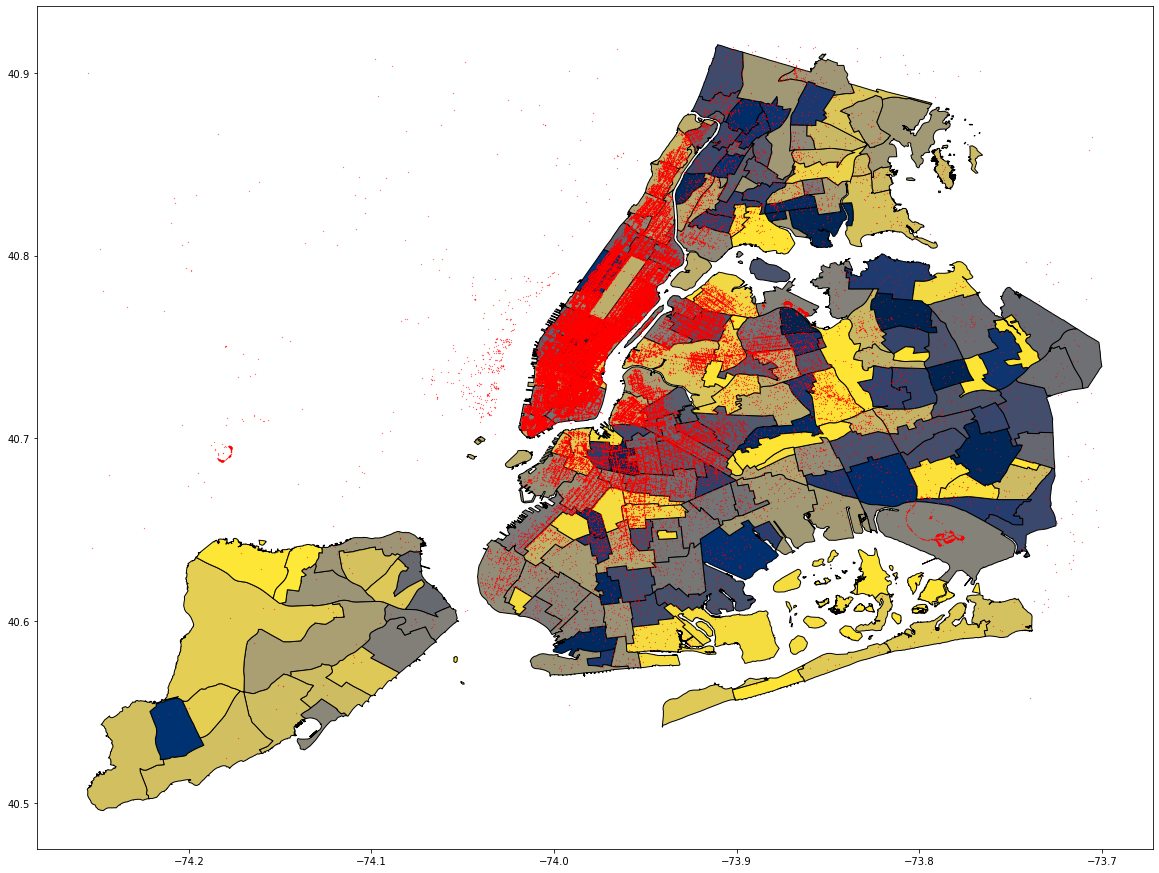

In [29]:
fig, ax = plt.subplots(figsize=(20,20))
#ax = world.plot( color='white', edgecolor='black',figsize = (50,50))
world.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")
Epoints.plot(ax=ax, color='red', markersize = 0.05)

Now we look at dropoffs

In [30]:
Edropoffs = df2['dropoff_datetime']>= int('00')
Edropoffs = df2['dropoff_datetime']<= int('05')
EdropoffsF = df2[Edropoffs]


In [31]:
EdropG = geopandas.GeoDataFrame(EdropoffsF, geometry=geopandas.points_from_xy(EdropoffsF.dropoff_longitude,EdropoffsF.dropoff_latitude))


In [32]:
Epointsd = EdropG.geometry

<AxesSubplot:>

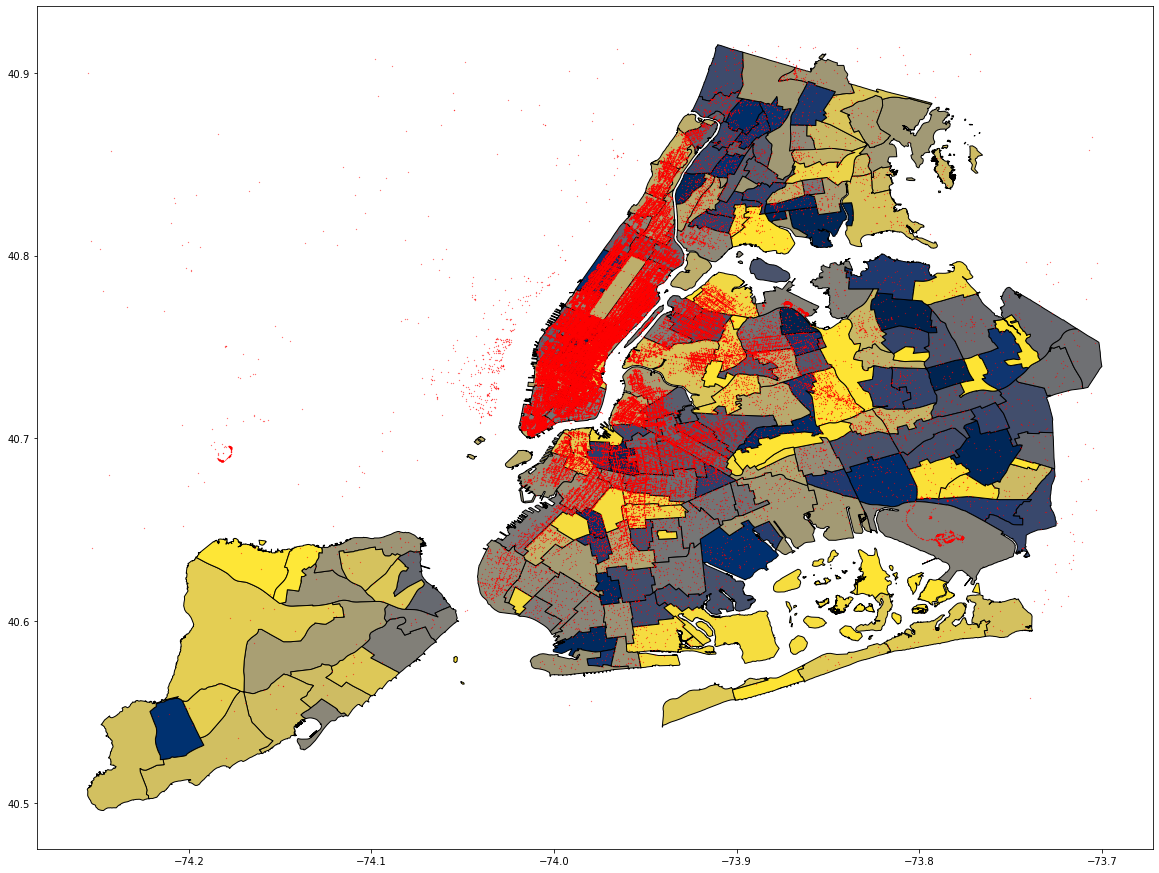

In [33]:
fig, ax = plt.subplots(figsize=(20,20))
#ax = world.plot( color='white', edgecolor='black',figsize = (50,50))
world.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")
Epointsd.plot(ax=ax, color='red', markersize = 0.05)

From our geoplots we can say that the busiest area for both dropoffs and pickups at midnight to 5am is definitely Manhattan. Again this makes sense since Manhattan is where most commercial and entertainment facilities are located, which is generally where people would be travelling to and from at these times of night. Our dropoffs are more scattered and dense in the outer boroughs which could signify people travelling home. Statten Island is our quietest borough, probably because it's quite seperated from the main landmass and is quite far away from the centre of Manhattan. This means people would be less inclined to travel the long distances to and from Statten, especially at late hours of the evening.